In [44]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [45]:
# Preprocesamiento de datos
def preprocess(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            if len(data[column].unique()) == 2:
                data[column] = pd.Categorical(data[column]).codes
            else:
                le = LabelEncoder()
                data[column] = le.fit_transform(data[column])
    return data

In [46]:
# Función de fitness para evaluar el subconjunto de características
def fitness_function(particle, X, y, model, min_features, max_features):
    num_features = np.count_nonzero(particle)
    if num_features == 0:
        return 0  # Peor fitness si no selecciona ninguna característica
    if num_features < min_features or num_features > max_features:
        penalty = 0.5  # Penalización si no cumple con las restricciones de número de características
    else:
        penalty = 1
    X_selected = X.iloc[:, particle == 1]
    model_clone = clone(model)
    try:
        score = np.mean(cross_val_score(model_clone, X_selected, y, cv=5, scoring='accuracy'))
    except ValueError:
        score = 0  # En caso de que haya problemas con el subconjunto de características seleccionado
    return score * penalty

In [47]:
# Algoritmo PSO para la selección de características
def feature_selection_pso(data, target_variable, model, n_particles=30, n_iterations=8, min_features=1, max_features=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    data = preprocess(data)
    X = data.drop(columns=[target_variable])
    y = data[target_variable]
    n_features = X.shape[1]

    if max_features is None:
        max_features = n_features

    # Inicializar las partículas y velocidades
    particles = np.random.choice([0, 1], size=(n_particles, n_features))
    velocities = np.random.uniform(-1, 1, (n_particles, n_features))

    # Asegurar que cada partícula tenga al menos el número mínimo de características y no más del máximo
    for i in range(n_particles):
        if np.count_nonzero(particles[i]) < min_features:
            selected_indices = np.random.choice(n_features, min_features, replace=False)
            particles[i, selected_indices] = 1
        elif np.count_nonzero(particles[i]) > max_features:
            deselected_indices = np.random.choice(np.where(particles[i] == 1)[0], np.count_nonzero(particles[i]) - max_features, replace=False)
            particles[i, deselected_indices] = 0

    # Inicializar el mejor global y los mejores personales
    pbest = particles.copy()
    pbest_scores = np.array([fitness_function(p, X, y, model, min_features, max_features) for p in particles])
    gbest_idx = np.argmax(pbest_scores)
    gbest = pbest[gbest_idx].copy()
    gbest_score = pbest_scores[gbest_idx]

    # Historial para la grafica
    gbest_score_history = []

    # Hiperparámetros de PSO
    w = 0.9  # Inercia inicial
    w_min = 0.4  # Inercia mínima
    c1 = 2.5  # Coeficiente cognitivo inicial
    c2 = 0.5  # Coeficiente social inicial

    # Iteraciones del PSO
    no_improvement_counter = 0  # Contador de iteraciones sin mejora
    max_no_improvement = 5  # Máximo número de iteraciones sin mejora antes de aplicar mutación

    for iteration in range(n_iterations):
        for i in range(n_particles):
            # Actualizar la velocidad
            r1 = np.random.rand(n_features)
            r2 = np.random.rand(n_features)
            cognitive = c1 * r1 * (pbest[i] - particles[i])
            social = c2 * r2 * (gbest - particles[i])
            velocities[i] = w * velocities[i] + cognitive + social

            # Actualizar la posición de la partícula usando la función sigmoide
            sigmoid = 1 / (1 + np.exp(-velocities[i]))
            particles[i] = np.where(np.random.rand(n_features) < sigmoid, 1, 0)

            # Asegurar que la partícula cumpla con el número mínimo y máximo de características
            if np.count_nonzero(particles[i]) < min_features:
                selected_indices = np.random.choice(n_features, min_features, replace=False)
                particles[i, selected_indices] = 1
            elif np.count_nonzero(particles[i]) > max_features:
                deselected_indices = np.random.choice(np.where(particles[i] == 1)[0], np.count_nonzero(particles[i]) - max_features, replace=False)
                particles[i, deselected_indices] = 0

            # Evaluar el nuevo subconjunto de características
            score = fitness_function(particles[i], X, y, model, min_features, max_features)

            # Actualizar el mejor personal
            if score > pbest_scores[i]:
                pbest[i] = particles[i].copy()
                pbest_scores[i] = score

            # Actualizar el mejor global
            if score > gbest_score:
                gbest = particles[i].copy()
                gbest_score = score
                no_improvement_counter = 0  # Reiniciar contador de iteraciones sin mejora
            else:
                no_improvement_counter += 1

        # Reducir el coeficiente de inercia
        w = max(w_min, w * 0.99)

        # Ajustar los coeficientes cognitivo y social
        c1 = max(0.5, c1 * 0.99)
        c2 = min(2.5, c2 * 1.01)

        # Aplicar mutación si no hay mejora
        if no_improvement_counter >= max_no_improvement:
            mutation_idx = np.random.randint(0, n_particles)
            particles[mutation_idx] = np.random.choice([0, 1], size=n_features)  # Reinicializar la partícula aleatoriamente
            if np.count_nonzero(particles[mutation_idx]) < min_features:
                selected_indices = np.random.choice(n_features, min_features, replace=False)
                particles[mutation_idx, selected_indices] = 1
            elif np.count_nonzero(particles[mutation_idx]) > max_features:
                deselected_indices = np.random.choice(np.where(particles[mutation_idx] == 1)[0], np.count_nonzero(particles[mutation_idx]) - max_features, replace=False)
                particles[mutation_idx, deselected_indices] = 0
            no_improvement_counter = 0

        # Guardar el mejor score de esta iteración
        gbest_score_history.append(gbest_score)
        print(f"Iteration {iteration+1}/{n_iterations}, Best Accuracy: {gbest_score}")

    # Imprimir resultados finales
    selected_features = X.columns[gbest == 1]
    print("\nBest Accuracy:", gbest_score)
    print("Number of Features in Subset:", np.sum(gbest))
    print("Individual:", gbest)
    print("Feature Subset :", list(selected_features))

    # Graficar la evolucion del mejor score
    plt.plot(range(1, n_iterations + 1), gbest_score_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Best Accuracy')
    plt.title('PSO Feature Selection')
    plt.grid()
    plt.show()

    return selected_features

Iteration 1/8, Best Accuracy: 0.9598091908091908
Iteration 2/8, Best Accuracy: 0.9598091908091908
Iteration 3/8, Best Accuracy: 0.9598091908091908
Iteration 4/8, Best Accuracy: 0.9598091908091908
Iteration 5/8, Best Accuracy: 0.9598091908091908
Iteration 6/8, Best Accuracy: 0.9598091908091908
Iteration 7/8, Best Accuracy: 0.9598091908091908
Iteration 8/8, Best Accuracy: 0.9598091908091908

Best Accuracy: 0.9598091908091908
Number of Features in Subset: 4
Individual: [0 1 0 1 0 1 1]
Feature Subset : ['forehead_width_cm', 'nose_wide', 'lips_thin', 'distance_nose_to_lip_long']


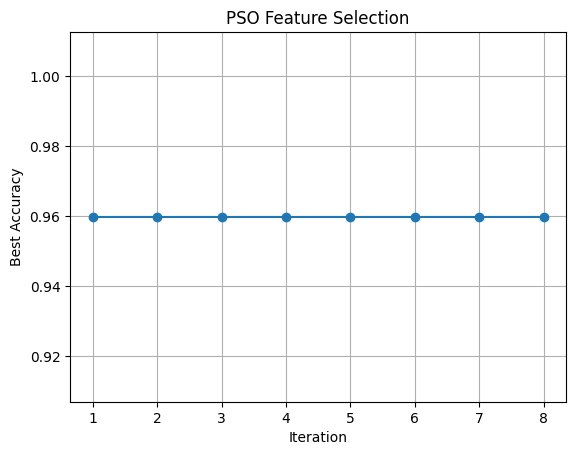

KNeighborsClassifier(n_neighbors=3)

In [48]:
# Parámetros de entrada
dataset_path = './datasets/gender.csv'
target_variable = 'gender'
seed = 100

# Cargar el dataset
data = pd.read_csv(dataset_path)

# Definir el modelo
model = KNeighborsClassifier( n_neighbors=3)

# Ejecutar la selección de características
selected_features = feature_selection_pso(data, target_variable, model, min_features=2, max_features=4, seed=seed)

# Preparar los datos con las características seleccionadas
data_selected = data[selected_features]
target = data[target_variable]

model.fit(data_selected, target)
